In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import requests
import io
import seaborn as sns
from tqdm.notebook import tqdm
import os
from zipfile import ZipFile

In [2]:
def load_biogrid_data(zip_path, organism_id=9606):  # 9606 is the taxonomy ID for Homo sapiens
    """
    Load BioGRID data from a local ZIP file and display key aspects of it.
    
    Parameters:
    zip_path (str): Path to the downloaded BioGRID ZIP file
    organism_id (int): NCBI Taxonomy ID for the organism (default: 9606 for Homo sapiens)
    
    Returns:
    pandas.DataFrame: BioGRID PPI data
    """
    print(f"Loading BioGRID data")
    
    # Open the zip file
    with ZipFile(zip_path) as z:
        # Find all .txt files in the archive
        txt_files = [f for f in z.namelist() if f.endswith('.txt')]
        
        if not txt_files:
            raise Exception("No text files found in the ZIP archive")
        
        # Use the first text file
        data_file = txt_files[0]
        print(f"Using file: {data_file}")
        
        # Read the file
        with z.open(data_file) as f:
            df = pd.read_csv(f, sep='\t', low_memory=False)
        
        # Filter for human PPIs
        human_df = df[(df['Organism Interactor A'] == organism_id) & (df['Organism Interactor B'] == organism_id)]
        print(f"Loaded {human_df.shape[0]} human ppi-interactions")
        #print("Available Columns:")
        #print(df.columns)

    column_name = "Experimental System"
    if column_name not in human_df.columns:
        print(f"Column '{column_name}' not found in the data.")
        print(f"Available columns: {', '.join(human_df.columns)}")
        return {}
    
    # Count experimental systems
    exp_system_counts = human_df[column_name].value_counts().to_dict()
    
    # Get total interactions
    total_interactions = sum(exp_system_counts.values())
    
    # Sort by count
    sorted_systems = sorted(exp_system_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Display table with counts and percentages
    print(f"\nExperimental System Distribution (Total: {total_interactions} interactions):")
    print("-" * 80)
    print(f"{'System Type':<40} | {'Count':>10} | {'Percentage':>10}")
    print("-" * 80)
    
    for system, count in sorted_systems:
        percentage = (count / total_interactions) * 100
        print(f"{system[:40]:<40} | {count:>10,} | {percentage:>9.2f}%")
            
    return human_df

In [3]:
def create_ppi_network(biogrid_df, interaction_type='physical'):
    """
    Create a PPI network from BioGRID data.
    
    Parameters:
    biogrid_df (pandas.DataFrame): BioGRID data
    interaction_type (str): Type of interaction to include ('physical', 'genetic', or 'all')
    
    Returns:
    networkx.Graph: PPI network
    """
    # Create an empty graph as a representation of the PPI network
    G = nx.Graph()
    
    # Filter by interaction type if specified
    if interaction_type == 'physical':
        df_filtered = biogrid_df[biogrid_df['Experimental System Type'] == 'physical']
    elif interaction_type == 'genetic':
        df_filtered = biogrid_df[biogrid_df['Experimental System Type'] == 'genetic']
    else:
        df_filtered = biogrid_df
    
    print(f"Building network with {df_filtered.shape[0]} physical interactions...")

     # Count statistics
    missing_symbols = 0
    self_interactions = 0
    duplicate_edges = 0
    added_edges = 0
    
    # Iterate through the edge dataset
    for _, row in tqdm(df_filtered.iterrows(), total=df_filtered.shape[0]):
        protein_a = row['Official Symbol Interactor A']
        protein_b = row['Official Symbol Interactor B']

        # Check for missing symbols
        if pd.isna(protein_a) or pd.isna(protein_b):
            missing_symbols += 1
            continue
        
        # Skip self-interactions if needed
        if protein_a == protein_b:
            self_interactions += 1
            continue
        
        # Add nodes with attributes
        if not G.has_node(protein_a):
            G.add_node(protein_a, entrez_id=row['Entrez Gene Interactor A']) # Add stable unique identifiers as well
        
        if not G.has_node(protein_b):
            G.add_node(protein_b, entrez_id=row['Entrez Gene Interactor B'])

        # Check if edge already exists
        if G.has_edge(protein_a, protein_b):
            duplicate_edges += 1
        else:
            added_edges += 1
        
        # Add edge with attributes
        if not G.has_edge(protein_a, protein_b):
            G.add_edge(protein_a, protein_b, 
                       exp_system=row['Experimental System'],
                       int_type=row['Experimental System Type'],
                       pubmed_id=row['Pubmed ID'])
        
    print(f"Network created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    print(f"  Interactions with missing symbols: {missing_symbols}")
    print(f"  Self-interactions: {self_interactions}")
    print(f"  Duplicate edges: {duplicate_edges}")
    print(f"  Unique edges added: {added_edges}")
    print(f"  Sum: {added_edges + duplicate_edges + self_interactions + missing_symbols}")
    
    return G

In [4]:
def analyze_network(G):
    """
    Analyze the properties of a PPI network.
    
    Parameters:
    G (networkx.Graph): PPI network
    
    Returns:
    dict: Network properties
    """    
    # Basic properties
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    
    # Calculate network density
    density = nx.density(G)
    
    # Find connected components
    connected_components = list(nx.connected_components(G))
    num_connected_components = len(connected_components)
    
    # Get the largest connected component
    largest_cc = max(connected_components, key=len)
    largest_cc_size = len(largest_cc)
    
    # Create a subgraph of the largest connected component
    G_lcc = G.subgraph(largest_cc).copy()
    
    # Calculate degree distribution
    degree_dict = dict(G.degree())
    degree_values = list(degree_dict.values())
     
    # Top 10 hub proteins (highest degree)
    hub_proteins = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]

    # Count interactions by experimental system
    exp_system_counts = {}
    for u, v, data in G.edges(data=True):
        # Get all values from the Experimental System column with "Unknown" for empty fields
        exp_system = data.get('exp_system', 'Unknown')
        if exp_system in exp_system_counts:
            exp_system_counts[exp_system] += 1
        else:
            exp_system_counts[exp_system] = 1
    # Sort experimental systems by count
    exp_system_counts = {k: v for k, v in sorted(exp_system_counts.items(), 
                                                key=lambda item: item[1], 
                                                reverse=True)}
    
    # Return network properties
    return {
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'density': density,
        'num_connected_components': num_connected_components,
        'degree_values': degree_values,
        'hub_proteins': hub_proteins,
        'largest_cc_size': largest_cc_size,
        'largest_cc': G_lcc,
        'exp_system_counts': exp_system_counts
    }

In [5]:
def visualize_network_properties(properties):
    """
    Visualize network properties.
    
    Parameters:
    properties (dict): Network properties
    
    Returns:
    None
    """
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    
    # Degree distribution
    axs[0, 0].hist(properties['degree_values'], bins=50, alpha=0.7, color='skyblue')
    axs[0, 0].set_title('Degree Distribution')
    axs[0, 0].set_xlabel('Degree')
    axs[0, 0].set_ylabel('Frequency')
    axs[0, 0].set_yscale('log')
    
    # Top 10 hub proteins
    hub_names = [hub[0] for hub in properties['hub_proteins']]
    hub_degrees = [hub[1] for hub in properties['hub_proteins']]
    
    axs[0, 1].barh(hub_names[::-1], hub_degrees[::-1], color='salmon')
    axs[0, 1].set_title('Top 10 Hub Proteins')
    axs[0, 1].set_xlabel('Degree')
    
    # Network statistics as a table
    stats = {
        'Statistic': ['Number of Nodes', 'Number of Edges', 'Network Density', 
                      'Number of Connected Components', 'Largest CC Size'],
        'Value': [properties['num_nodes'], properties['num_edges'], 
                  f"{properties['density']:.6f}", properties['num_connected_components'], 
                  properties['largest_cc_size']]
    }
    
    axs[1, 0].axis('off')
    table = axs[1, 0].table(cellText=list(zip(stats['Statistic'], stats['Value'])),
                          loc='center', cellLoc='left', colWidths=[0.6, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    # Experimental System Distribution
    if 'exp_system_counts' in properties:
        # Get the top 10 experimental systems
        sorted_systems = sorted(properties['exp_system_counts'].items(), 
                               key=lambda x: x[1], 
                               reverse=True)[:10]
        
        if sorted_systems:
            systems = [s[0] for s in sorted_systems]
            counts = [s[1] for s in sorted_systems]
            
            # Create a simple bar chart
            y_pos = range(len(systems))
            axs[1, 1].barh(y_pos, counts, color='lightgreen')
            axs[1, 1].set_yticks(y_pos)
            axs[1, 1].set_yticklabels(systems)
            axs[1, 1].set_title('Top 10 Experimental Systems')
            axs[1, 1].set_xlabel('Number of Interactions')
    else:
        axs[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [6]:
def visualize_network(G, layout='spring', node_size_factor=10, max_nodes=500):
    """
    Visualize a PPI network.
    
    Parameters:
    G (networkx.Graph): PPI network
    layout (str): Layout algorithm ('spring', 'circular', 'kamada_kawai', 'spectral')
    node_size_factor (int): Factor to scale node sizes by degree
    max_nodes (int): Maximum number of nodes to visualize
    
    Returns:
    None
    """
    # If the network is too large, take a subgraph based on the nodes with the most degrees
    if G.number_of_nodes() > max_nodes:
        print(f"Network is too large ({G.number_of_nodes()} nodes). Visualizing a subgraph of {max_nodes} nodes with highest degrees...")
        # Get the nodes with highest degree
        node_degrees = dict(G.degree())
        top_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)[:max_nodes]
        top_node_names = [node for node, _ in top_nodes]
        G_vis = G.subgraph(top_node_names).copy()
    else:
        G_vis = G
    
    # Create figure
    plt.figure(figsize=(12, 12))
    
    # Choose layout
    if layout == 'spring':
        pos = nx.spring_layout(G_vis, seed=42)
    elif layout == 'circular':
        pos = nx.circular_layout(G_vis)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G_vis)
    elif layout == 'spectral':
        pos = nx.spectral_layout(G_vis)
    else:
        pos = nx.spring_layout(G_vis, seed=42)
    
    # Get node degrees for sizing
    node_degrees = dict(G_vis.degree())
    node_sizes = [node_size_factor * (degree + 1) for node, degree in node_degrees.items()]
    
    # Draw nodes
    nx.draw_networkx_nodes(G_vis, pos, node_size=node_sizes, node_color='lightblue', alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(G_vis, pos, width=0.5, alpha=0.5)
    
    # Draw labels for high-degree nodes
    high_degree_nodes = {node: node for node, degree in node_degrees.items() if degree > np.percentile(list(node_degrees.values()), 95)}
    nx.draw_networkx_labels(G_vis, pos, labels=high_degree_nodes, font_size=10, font_weight='bold')
    
    plt.title(f'Human PPI Network ({G_vis.number_of_nodes()} proteins, {G_vis.number_of_edges()} interactions)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
def visualize_network_with_highlights(G, csv_file="genes_groups_26_27.csv", layout='spring', 
                                    node_size_factor=10, max_nodes=500, 
                                    highlight_color='red', regular_color='lightblue'):
    """
    Visualize a PPI network with highlighted genes.
    
    Parameters:
    G (networkx.Graph): PPI network
    layout (str): Layout algorithm ('spring', 'circular', 'kamada_kawai', 'spectral')
    node_size_factor (int): Factor to scale node sizes by degree
    max_nodes (int): Maximum number of nodes to visualize
    highlight_color (str): Color for highlighted genes
    regular_color (str): Color for regular genes
    
    Returns:
    None
    """
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Check if the gene column exists
    gene_column = "Gene"
    if gene_column not in df.columns:
        print(f"Column '{gene_column}' not found in the CSV file.")
        print(f"Available columns: {', '.join(df.columns)}")
        return set()
    
    # Extract gene symbols and convert to a set
    highlight_genes = set(df[gene_column].dropna().unique())
    
    print(f"Loaded {len(highlight_genes)} unique genes from {csv_file}")

    # If no genes to highlight, use regular visualization
    if highlight_genes is None or len(highlight_genes) == 0:
        visualize_network(G, layout, node_size_factor, max_nodes)
        return
    
    # Filter network to include highlighted genes and their neighbors
    highlight_genes_in_network = set(highlight_genes).intersection(set(G.nodes()))
    
    print(f"Found {len(highlight_genes_in_network)} of {len(highlight_genes)} genes in the network")
    
    # If network is too large, take a subgraph focused on highlighted genes
    if G.number_of_nodes() > max_nodes:
        # First include all highlighted genes
        included_nodes = set(highlight_genes_in_network)
        
        # Then add neighbors of highlighted genes
        for gene in highlight_genes_in_network:
            included_nodes.update(G.neighbors(gene))
        
        # Add highest degree nodes not already included
        remaining_slots = max_nodes - len(included_nodes)
        if remaining_slots > 0:
            # Get nodes not already included, sorted by degree
            node_degrees = dict(G.degree())
            remaining_nodes = [(node, degree) for node, degree in node_degrees.items() 
                              if node not in included_nodes]
            top_remaining = sorted(remaining_nodes, key=lambda x: x[1], reverse=True)[:remaining_slots]
            # Add these high-degree nodes
            included_nodes.update([node for node, _ in top_remaining])
        
        # Create the subgraph
        G_vis = G.subgraph(included_nodes).copy()
        print(f"Created subgraph with {G_vis.number_of_nodes()} nodes and {G_vis.number_of_edges()} edges")
    else:
        G_vis = G
    
    # Create figure
    plt.figure(figsize=(14, 14))
    
    # Choose layout
    if layout == 'spring':
        pos = nx.spring_layout(G_vis, seed=42)
    elif layout == 'circular':
        pos = nx.circular_layout(G_vis)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G_vis)
    elif layout == 'spectral':
        pos = nx.spectral_layout(G_vis)
    else:
        pos = nx.spring_layout(G_vis, seed=42)
    
    # Get node degrees for sizing
    node_degrees = dict(G_vis.degree())
    
    # Create node lists and sizes for highlighted and regular nodes
    highlighted_nodes = [node for node in G_vis.nodes() if node in highlight_genes]
    regular_nodes = [node for node in G_vis.nodes() if node not in highlight_genes]
    
    highlighted_sizes = [node_size_factor * (node_degrees[node] + 1) * 1.5 for node in highlighted_nodes]
    regular_sizes = [node_size_factor * (node_degrees[node] + 1) for node in regular_nodes]
    
    # Draw regular nodes
    nx.draw_networkx_nodes(G_vis, pos, nodelist=regular_nodes, 
                          node_size=regular_sizes, node_color=regular_color, alpha=0.7)
    
    # Draw highlighted nodes
    if highlighted_nodes:
        nx.draw_networkx_nodes(G_vis, pos, nodelist=highlighted_nodes, 
                              node_size=highlighted_sizes, node_color=highlight_color, alpha=0.9)
    
    # Draw edges
    nx.draw_networkx_edges(G_vis, pos, width=0.5, alpha=0.5)
    
    # Label all highlighted nodes
    highlighted_labels = {node: node for node in highlighted_nodes}
    nx.draw_networkx_labels(G_vis, pos, labels=highlighted_labels, 
                           font_size=10, font_weight='bold')
    
    # Title and layout
    plt.title(f'PPI Network with Disease Genes ({len(highlighted_nodes)} genes highlighted)')
    plt.axis('off')
    plt.tight_layout()    
    plt.show()
    
    # Also create a subnetwork of just the highlighted genes and their direct neighbors
    if len(highlighted_nodes) > 0:
        highlight_subnetwork = G.subgraph(highlighted_nodes).copy() # Includes all edges that connect pairs of nodes
        
        if highlight_subnetwork.number_of_edges() > 0:
            plt.figure(figsize=(12, 12))
            plt.title(f"Interactions Between Disease Genes ({highlight_subnetwork.number_of_edges()} interactions)")
            
            # Use a different layout for clarity
            pos = nx.spring_layout(highlight_subnetwork, seed=42)
            
            node_sizes = [node_size_factor * 5 * (dict(highlight_subnetwork.degree())[node] + 1) 
                         for node in highlight_subnetwork.nodes()]
            
            nx.draw_networkx_nodes(highlight_subnetwork, pos, node_size=node_sizes, 
                                  node_color=highlight_color, alpha=0.9)
            nx.draw_networkx_edges(highlight_subnetwork, pos, width=1.0, alpha=0.7)
            nx.draw_networkx_labels(highlight_subnetwork, pos, font_size=10, font_weight='bold')
            
            plt.axis('off')
            plt.tight_layout()
            plt.show()
        else:
            print("No direct interactions found between highlighted genes")

Loading BioGRID data
Using file: BIOGRID-MV-Physical-4.4.245.tab2.txt
Loaded 318015 human ppi-interactions

Experimental System Distribution (Total: 318015 interactions):
--------------------------------------------------------------------------------
System Type                              |      Count | Percentage
--------------------------------------------------------------------------------
Affinity Capture-MS                      |    124,227 |     39.06%
Affinity Capture-Western                 |     61,914 |     19.47%
Proximity Label-MS                       |     28,720 |      9.03%
Reconstituted Complex                    |     27,385 |      8.61%
Co-fractionation                         |     22,161 |      6.97%
Two-hybrid                               |     21,778 |      6.85%
Biochemical Activity                     |      9,542 |      3.00%
Cross-Linking-MS (XL-MS)                 |      8,267 |      2.60%
Co-localization                          |      3,648 |      1.1

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,Pubmed ID,Organism Interactor A,Organism Interactor B,Throughput,Score,Modification,Phenotypes,Qualifications,Tags,Source Database
0,103,6416,2318,112315,108607,-,-,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,...,9006895,9606,9606,Low Throughput,-,-,-,-,-,BIOGRID
1,278,2624,5371,108894,111384,-,-,GATA2,PML,DCML|IMD21|MONOMAC|NFE1B,...,10938104,9606,9606,Low Throughput,-,-,-,-,-,BIOGRID
2,418,6118,6774,112038,112651,RP4-547C9.3,-,RPA2,STAT3,REPA2|RP-A p32|RP-A p34|RPA32,...,10875894,9606,9606,Low Throughput,-,-,-,-,-,BIOGRID
3,586,375,23163,106870,116775,-,-,ARF1,GGA3,-,...,10747089,9606,9606,Low Throughput,-,-,-,-,-,BIOGRID
4,612,377,23647,106872,117174,-,-,ARF3,ARFIP2,-,...,9038142,9606,9606,Low Throughput,-,-,-,-,-,BIOGRID


Building network with 318015 physical interactions...


  0%|          | 0/318015 [00:00<?, ?it/s]

Network created with 11553 nodes and 89993 edges
  Interactions with missing symbols: 0
  Self-interactions: 5931
  Duplicate edges: 222091
  Unique edges added: 89993
  Sum: 318015


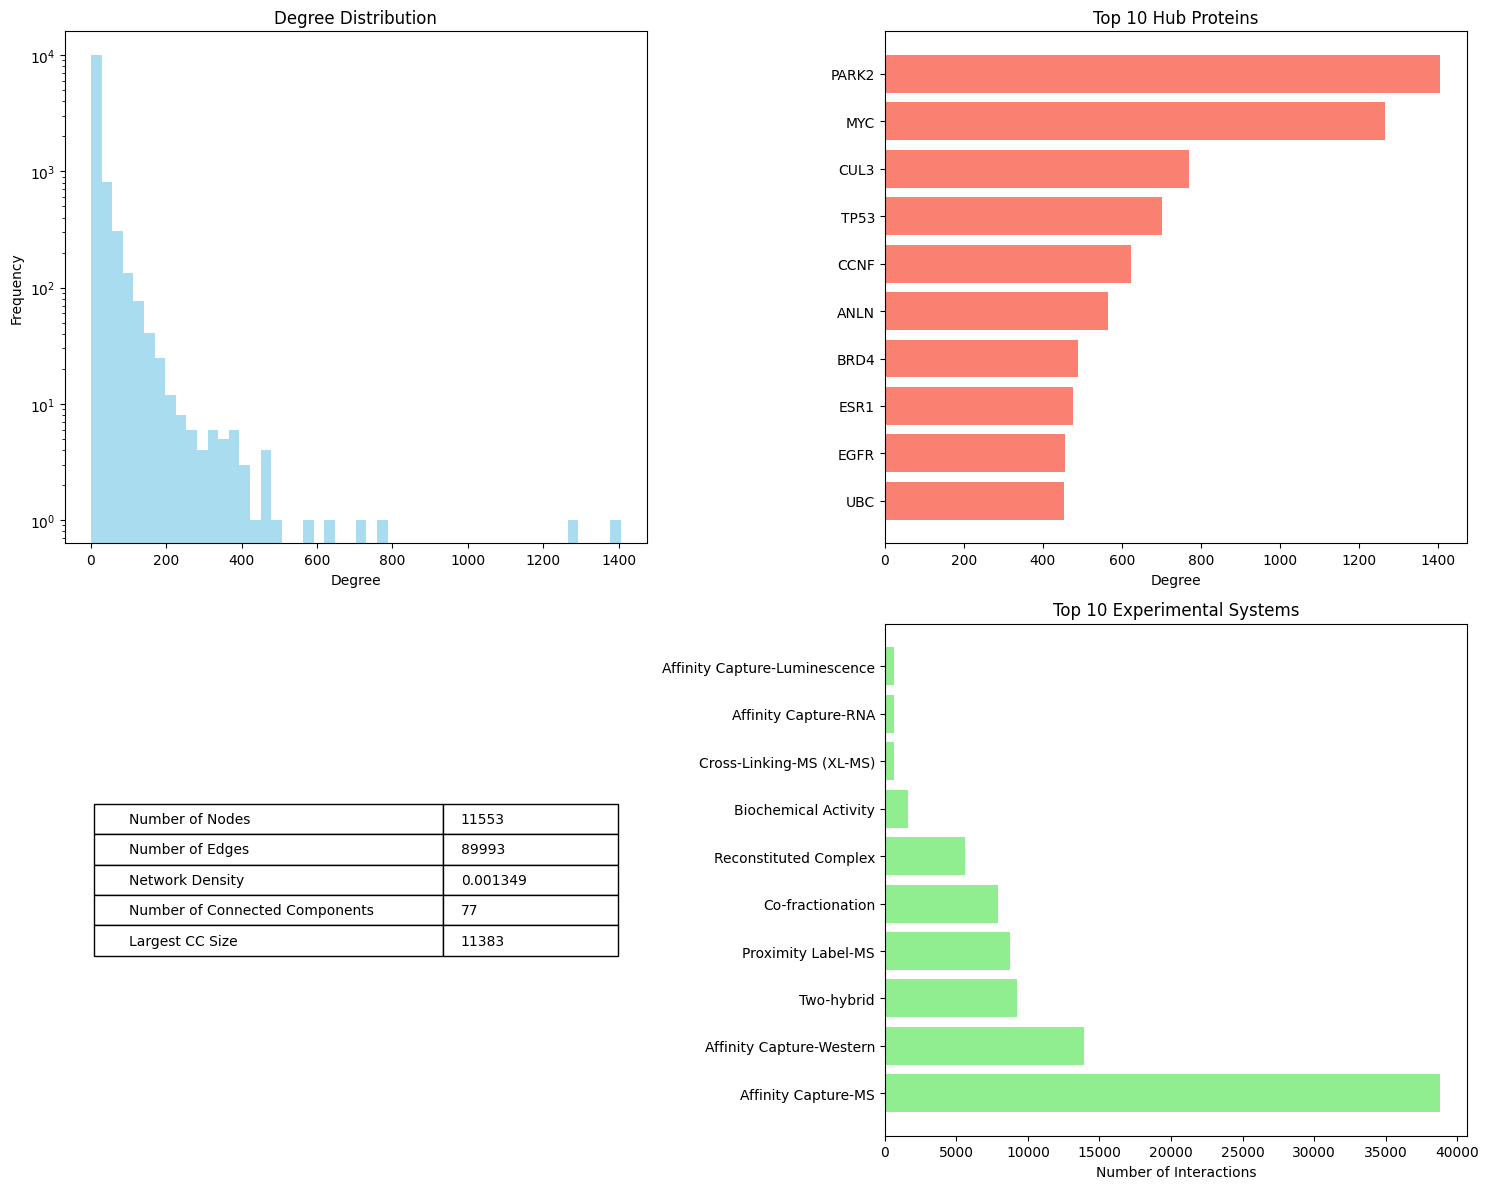

Network is too large (11383 nodes). Visualizing a subgraph of 300 nodes...


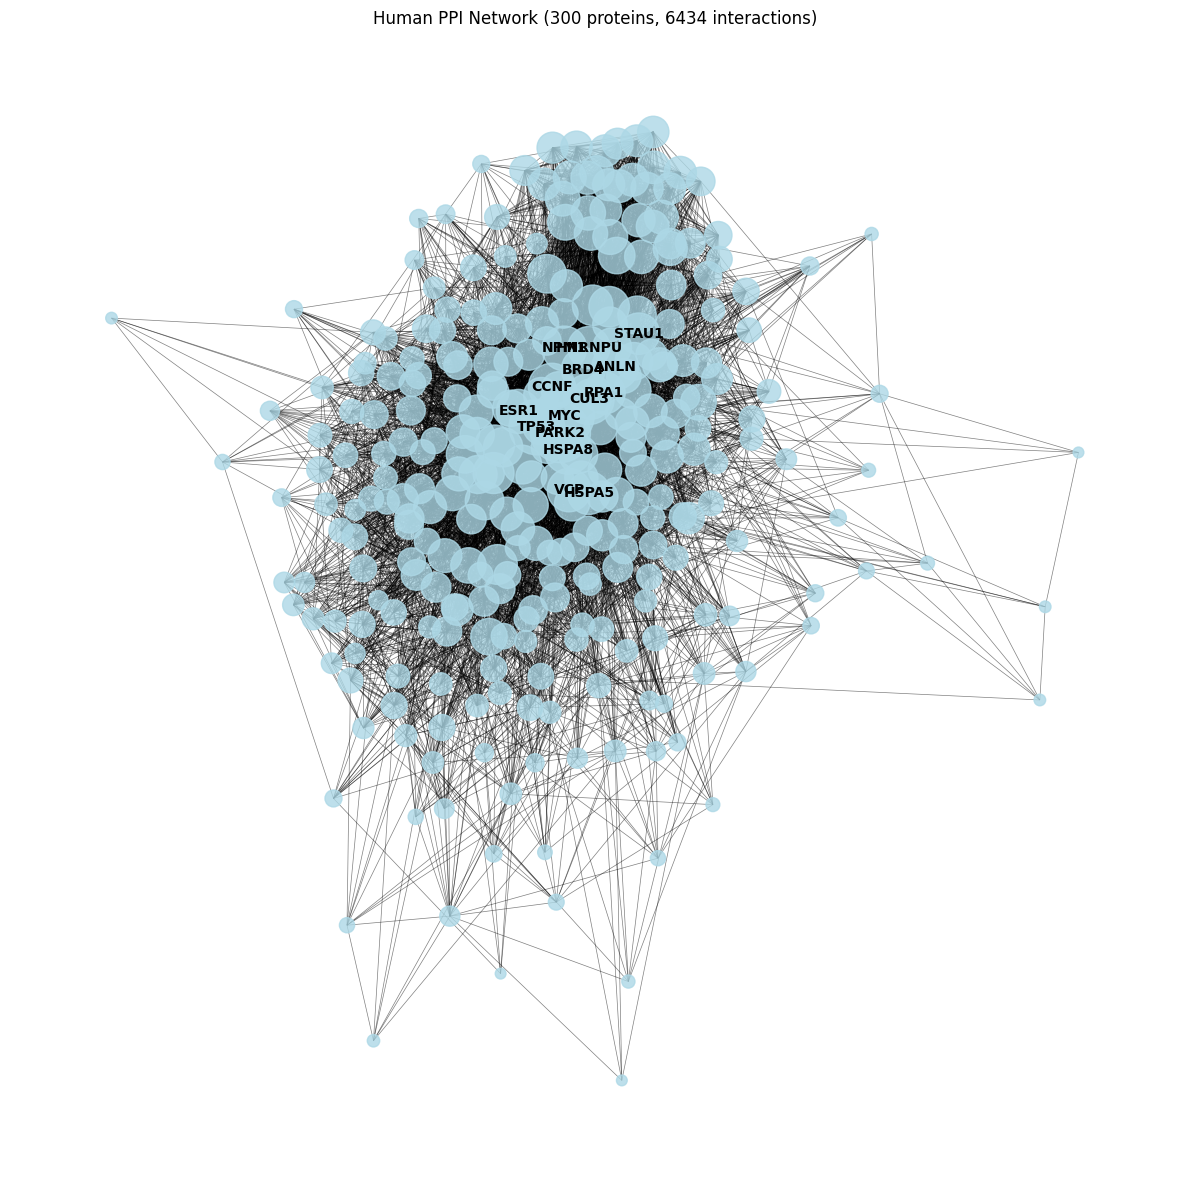

Loaded 58 unique genes from genes_groups_26_27.csv
Found 40 of 58 genes in the network
Created subgraph with 688 nodes and 5721 edges


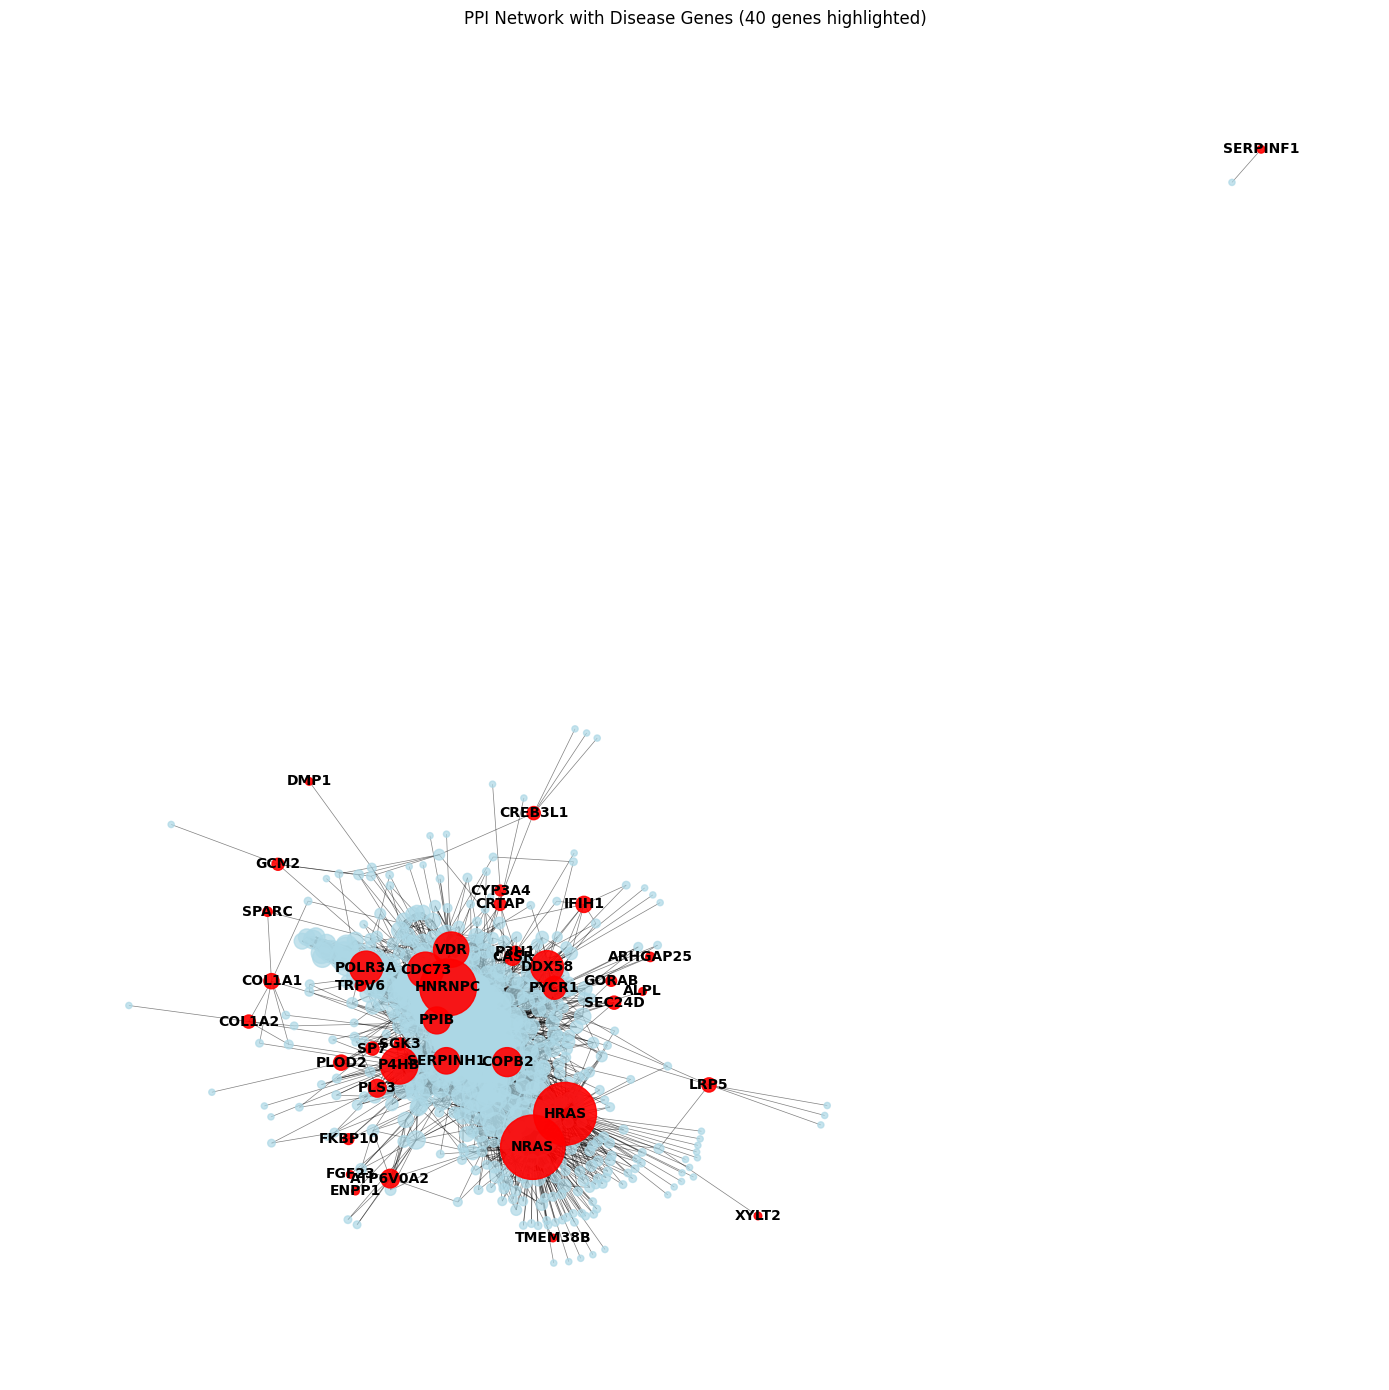

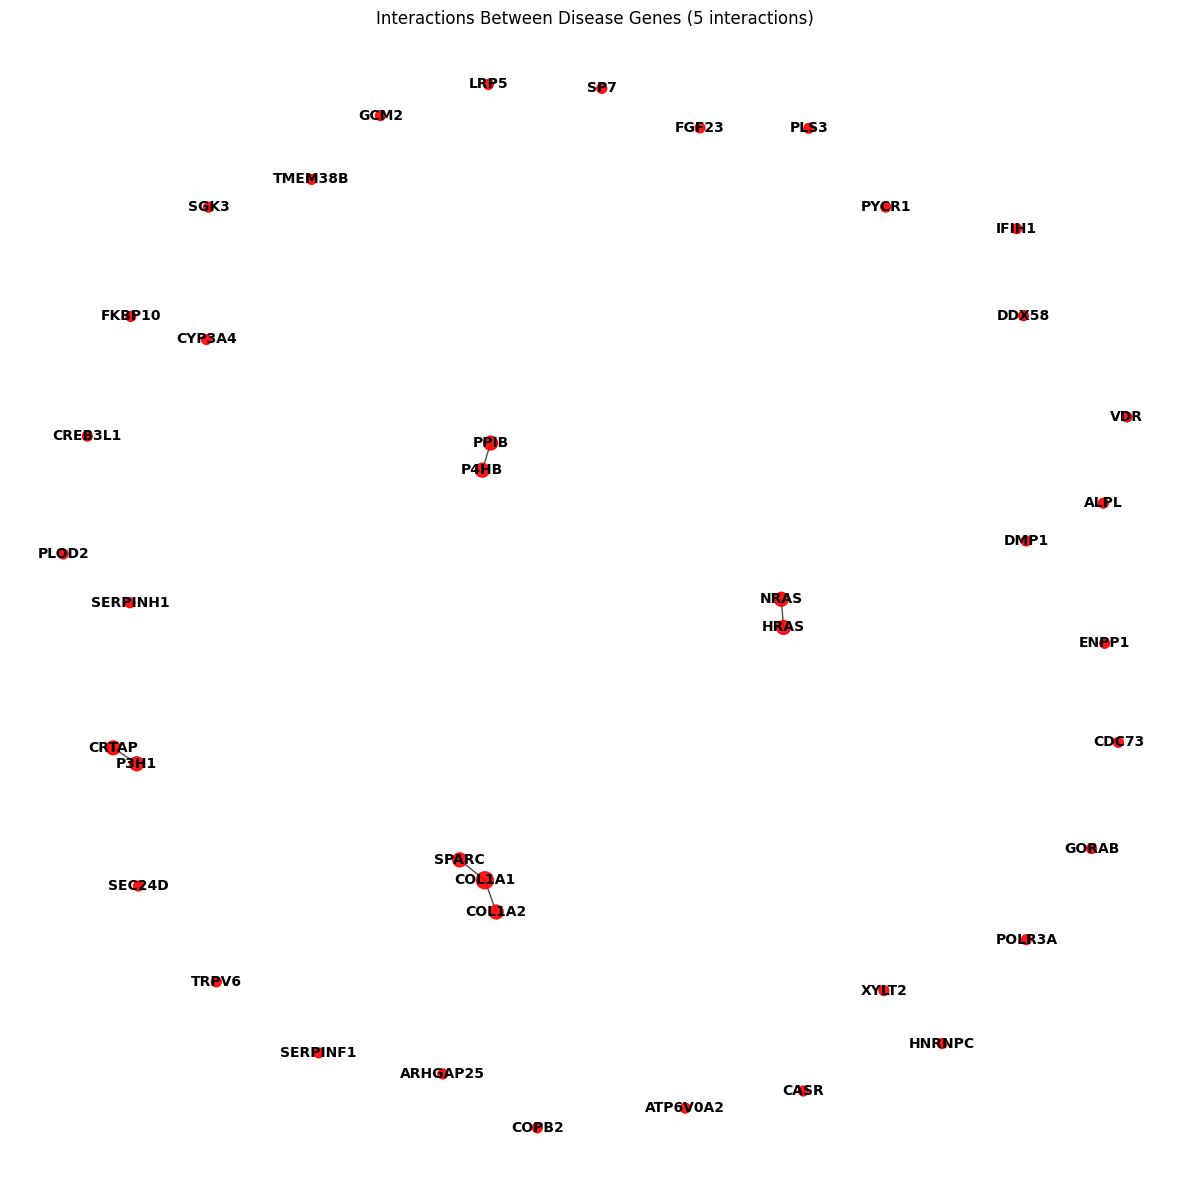

In [8]:
def main(zip_path, query_proteins=None):
    """
    Main execution function.
    
    Parameters:
    zip_path (str): Path to the downloaded BioGRID ZIP file
    query_proteins (list, optional): List of proteins to analyze
    
    Returns:
    none
    """
    # Load BioGRID data
    biogrid_df = load_biogrid_data(zip_path)
    display(biogrid_df.head())

    # Create PPI network
    ppi_network = create_ppi_network(biogrid_df, interaction_type='physical')

    # Analyze network properties
    network_properties = analyze_network(ppi_network)

    # Visualize network properties
    visualize_network_properties(network_properties)
    
    # Visualize the largest connected component of the network
    visualize_network(network_properties['largest_cc'], layout='spring', max_nodes=300)

    # Visualize network with highlighted genes
    visualize_network_with_highlights(ppi_network, max_nodes=300)

main('BIOGRID-MV-Physical-4.4.245.tab2.zip')

In [9]:
# Function to find proteins interacting with a query protein
def find_interactors(G, query_protein, degree=1):
    """
    Find proteins interacting with a query protein.
    
    Parameters:
    G (networkx.Graph): PPI network
    query_protein (str): Protein symbol
    degree (int): Degree of separation (1 for direct interactors, 2 for second-degree, etc.)
    
    Returns:
    set: Interacting proteins
    """
    if query_protein not in G:
        print(f"Protein {query_protein} not found in the network")
        return set()
    
    interactors = set()
    current_degree = 1
    current_nodes = {query_protein}
    visited = {query_protein}
    
    while current_degree <= degree:
        next_nodes = set()
        for node in current_nodes:
            neighbors = set(G.neighbors(node))
            next_nodes.update(neighbors - visited)
            if current_degree == 1:
                interactors.update(neighbors)
        
        visited.update(next_nodes)
        current_nodes = next_nodes
        current_degree += 1
    
    return interactors

# Function to find shortest paths between proteins
def find_paths(G, protein_a, protein_b, max_paths=3):
    """
    Find shortest paths between two proteins.
    
    Parameters:
    G (networkx.Graph): PPI network
    protein_a (str): Source protein symbol
    protein_b (str): Target protein symbol
    max_paths (int): Maximum number of paths to find
    
    Returns:
    list: List of paths
    """
    if protein_a not in G or protein_b not in G:
        print(f"One or both proteins ({protein_a}, {protein_b}) not found in the network")
        return []
    
    try:
        paths = list(nx.all_shortest_paths(G, protein_a, protein_b))
        return paths[:max_paths]
    except nx.NetworkXNoPath:
        print(f"No path found between {protein_a} and {protein_b}")
        return []

# Function to analyze specific biological processes or pathways in the network
def analyze_pathway_enrichment(G, protein_set, pathway_db=None):
    """
    Analyze pathway enrichment of a set of proteins.
    
    Parameters:
    G (networkx.Graph): PPI network
    protein_set (set): Set of proteins to analyze
    pathway_db (dict, optional): Dictionary mapping pathway names to sets of proteins
    
    Returns:
    dict: Enrichment analysis results
    """
    # If no pathway database is provided, create a simple example
    if pathway_db is None:
        # This is a placeholder. In a real analysis, you'd use a proper pathway database
        pathway_db = {
            "DNA Repair": {"TP53", "BRCA1", "BRCA2", "ATM", "RAD51"},
            "Cell Cycle": {"TP53", "CDK1", "CCNB1", "CDC20", "CDKN1A"},
            "Apoptosis": {"TP53", "BAX", "BCL2", "CASP3", "CASP9"}
        }
    
    # Calculate enrichment for each pathway
    enrichment_results = {}
    for pathway, pathway_proteins in pathway_db.items():
        # Calculate overlap
        overlap = protein_set.intersection(pathway_proteins)
        
        if len(overlap) > 0:
            # Calculate enrichment score (simple overlap percentage)
            enrichment_score = len(overlap) / len(pathway_proteins)
            
            enrichment_results[pathway] = {
                "overlap_size": len(overlap),
                "pathway_size": len(pathway_proteins),
                "enrichment_score": enrichment_score,
                "overlapping_proteins": overlap
            }
    
    # Sort results by enrichment score
    sorted_results = {k: v for k, v in sorted(
        enrichment_results.items(), 
        key=lambda item: item[1]["enrichment_score"], 
        reverse=True
    )}
    
    return sorted_results

# Function to analyze communities/modules in the network
def detect_network_communities(G, algorithm='louvain'):
    """
    Detect communities in the PPI network.
    
    Parameters:
    G (networkx.Graph): PPI network
    algorithm (str): Community detection algorithm ('louvain', 'label_propagation')
    
    Returns:
    dict: Community assignment for each node
    """
    try:
        import community as community_louvain
        from networkx.algorithms import community
        
        if algorithm == 'louvain':
            # Louvain method for community detection
            partition = community_louvain.best_partition(G)
            
        elif algorithm == 'label_propagation':
            # Label propagation method
            communities = community.label_propagation_communities(G)
            partition = {node: i for i, comm in enumerate(communities) for node in comm}
            
        else:
            print(f"Unknown algorithm: {algorithm}. Using Louvain method.")
            partition = community_louvain.best_partition(G)
        
        # Count the number of communities and their sizes
        community_sizes = {}
        for community_id in set(partition.values()):
            community_sizes[community_id] = sum(1 for v in partition.values() if v == community_id)
        
        print(f"Detected {len(community_sizes)} communities")
        print(f"Largest community has {max(community_sizes.values())} nodes")
        
        return partition, community_sizes
        
    except ImportError:
        print("Community detection requires additional packages.")
        print("Install them with: pip install python-louvain networkx>=2.5")
        return None, None

# Main execution 
def main(zip_path, query_proteins=None):
    """
    Main execution function.
    
    Parameters:
    zip_path (str): Path to the downloaded BioGRID ZIP file
    query_proteins (list, optional): List of proteins to analyze
    
    Returns:
    tuple: (BioGRID dataframe, PPI network, network properties)
    """
    # Load BioGRID data
    biogrid_df = load_biogrid_data(zip_path)
    
    # Display the first few rows to understand the data
    print("\nBioGRID data preview:")
    display(biogrid_df.head())
    
    # Display column names
    print("\nBioGRID columns:")
    for i, col in enumerate(biogrid_df.columns):
        print(f"{i+1}. {col}")
    
    # Create a PPI network with only physical interactions
    print("\nCreating physical PPI network...")
    ppi_network = create_ppi_network(biogrid_df, interaction_type='physical')
    
    # Analyze network properties
    print("\nAnalyzing network properties...")
    network_properties = analyze_network(ppi_network)
    
    # Visualize network properties
    print("\nVisualizing network properties...")
    visualize_network_properties(network_properties)
    
    # Visualize the network (largest connected component)
    print("\nVisualizing network (largest connected component)...")
    visualize_network(network_properties['largest_cc'], layout='spring', max_nodes=300)
    
    # Define query proteins if not provided
    if query_proteins is None:
        query_proteins = ["TP53", "BRCA1", "EGFR"]
    
    # Analyze each query protein
    for query_protein in query_proteins:
        if query_protein in ppi_network:
            print(f"\nAnalyzing {query_protein}...")
            
            # Find interactors
            interactors = find_interactors(ppi_network, query_protein)
            print(f"Found {len(interactors)} interactors for {query_protein}")
            
            # Create and visualize subnetwork for this protein
            if len(interactors) > 0:
                interactors_and_query = interactors.union({query_protein})
                subnetwork = ppi_network.subgraph(interactors_and_query).copy()
                
                # Visualize subnetwork
                print(f"Visualizing subnetwork for {query_protein}...")
                visualize_network(subnetwork, layout='spring')
                
                # Show top interactors
                degree_dict = dict(subnetwork.degree())
                # Remove the query protein itself
                if query_protein in degree_dict:
                    del degree_dict[query_protein]
                    
                top_interactors = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
                print(f"Top interactors of {query_protein}:")
                for protein, degree in top_interactors:
                    print(f"  {protein}: {degree} connections")
        else:
            print(f"\nProtein {query_protein} not found in the network")
    
    # Find paths between proteins (if applicable)
    if len(query_proteins) >= 2:
        protein_a, protein_b = query_proteins[0], query_proteins[1]
        print(f"\nFinding paths between {protein_a} and {protein_b}...")
        paths = find_paths(ppi_network, protein_a, protein_b)
        for i, path in enumerate(paths):
            print(f"Path {i+1}: {' -> '.join(path)}")
    
    return biogrid_df, ppi_network, network_properties